# Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
import time
from scipy.special import softmax
from scipy.spatial.distance import cdist
from scipy.optimize import minimize_scalar
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score


# Synthetic Dataset

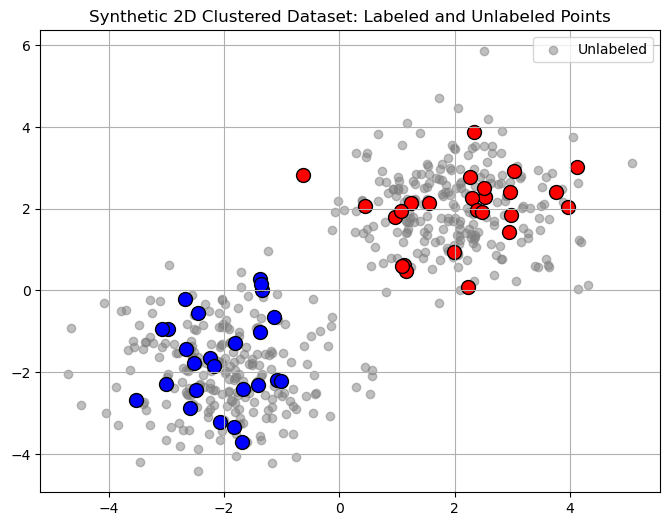

In [3]:
np.random.seed(42)

n_points = 500
labeled_fraction = 0.1
num_unlabeled = int(n_points * (1 - labeled_fraction))

X, true_labels = make_blobs(
    n_samples=n_points,
    centers=[[2, 2], [-2, -2]],
    cluster_std=1.0, 
    random_state=42
)

labels = np.full(n_points, None)
n_labeled = int(n_points * labeled_fraction)

cluster_0_indices = np.where(true_labels == 0)[0]
cluster_1_indices = np.where(true_labels == 1)[0]

labeled_idx_0 = np.random.choice(cluster_0_indices, size=n_labeled // 2, replace=False)
labeled_idx_1 = np.random.choice(cluster_1_indices, size=n_labeled // 2, replace=False)

labeled_indices = np.concatenate([labeled_idx_0, labeled_idx_1])

# Assign labels (+1 or -1) to the labeled points
labels[labeled_idx_0] = -1
labels[labeled_idx_1] = 1
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c='gray', label='Unlabeled', alpha=0.5)

for idx in labeled_indices:
    color = 'red' if labels[idx] == -1 else 'blue'
    plt.scatter(X[idx, 0], X[idx, 1], color=color, edgecolor='black', s=100)

plt.legend()
plt.title('Synthetic 2D Clustered Dataset: Labeled and Unlabeled Points')
plt.grid(True)
plt.show()


# Exponential Similarity Measure

The exponential similarity measure evaluates point relationships using:

$$
K(x, y) = \exp\left( -\gamma \|x - y\|^2 \right)
$$

**Key Properties:**
- Output range: (0, 1] (1 for identical points)
- Symmetric: $K(x, y) = K(y, x)$
- $\gamma$ controls similarity decay rate:
  - High $\gamma$: Focuses on very close neighbors
  - Low $\gamma$: Broader similarity range

In [4]:
def similarity_matrix(X1, X2, sigma=1.0):
    return np.exp(-sigma * cdist(X1, X2, 'sqeuclidean'))

labeled_indices = np.where(labels != None)[0]
unlabeled_indices = np.where(labels == None)[0]

W_lu = similarity_matrix(X[labeled_indices], X[unlabeled_indices])
W_uu = similarity_matrix(X[unlabeled_indices], X[unlabeled_indices])


# 1. Gradient Descent
## 1.1. Fixed Step

In [5]:
def compute_loss(y_u, y_l, W_lu, W_uu):
    loss_1 = np.sum(W_lu * (y_u[None, :] - y_l[:, None])**2)
    diff = y_u[None, :] - y_u[:, None]
    loss_2 = 0.5 * np.sum(W_uu * diff**2)
    return loss_1 + loss_2

def compute_grad(y_u, y_l, W_lu, W_uu):
    term1 = 2 * np.sum(W_lu * (y_u[None, :] - y_l[:, None]), axis=0)
    term2 = 2 * np.sum(W_uu * (y_u[:, None] - y_u[None, :]), axis=1)
    return term1 + term2

def lipschitz_constant(W_lu, W_uu, unlabeled_indices):
    n = len(unlabeled_indices)
    hessian = -2 * W_uu.astype(np.float64)
    diag = np.zeros(n)
    for k in range(n):
        diag[k] = 2 * (np.sum(W_lu[:, k].astype(np.float64)) + np.sum(W_uu[:, k].astype(np.float64)))
    np.fill_diagonal(hessian, diag)
    eigenvals = np.linalg.eigvalsh(hessian)
    return np.amax(eigenvals)

def plot_loss(hist_df):
    plt.figure(figsize=(8, 4))
    plt.plot(hist_df['iter'], hist_df['loss'])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss over iterations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def gradient_descent_fixed_step(W_lu, W_uu, y_l, unlabeled_indices, max_iter=1000, tol=1e-2, verbose=False):
    y_u = np.zeros(len(unlabeled_indices), dtype=np.float64)
    hist = []
    
    W_lu = W_lu.astype(np.float64)
    W_uu = W_uu.astype(np.float64)
    y_l = y_l.astype(np.float64)
    
    initial_loss = compute_loss(y_u, y_l, W_lu, W_uu)
    hist.append({'iter': 0, 'loss': initial_loss, 'grad_norm': np.nan})
    
    L = lipschitz_constant(W_lu, W_uu, unlabeled_indices)
    step_size = np.float64(1.0 / L)
    prev_loss = initial_loss

    for i in range(1, max_iter):
        grad = compute_grad(y_u, y_l, W_lu, W_uu).astype(np.float64)
        y_u = y_u.astype(np.float64) - step_size * grad
        loss = compute_loss(y_u, y_l, W_lu, W_uu)
        grad_norm = np.linalg.norm(grad)
        hist.append({'iter': i, 'loss': loss, 'grad_norm': grad_norm})

        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss

    return y_u, pd.DataFrame(hist)

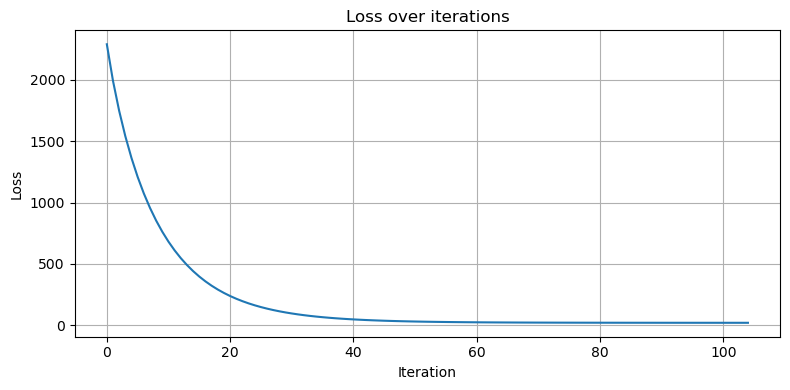

In [6]:
y_u, hist_df = gradient_descent_fixed_step(W_lu, W_uu, labels[labeled_indices], unlabeled_indices, verbose=True)
plot_loss(hist_df)

In [8]:
hist_df

,iter,loss,grad_norm
0,0,2290.918483,NaN
1,1,1992.383827,236.156487
2,2,1748.157357,212.276633
3,3,1541.428697,194.821763
4,4,1363.726341,180.386095
...,...,...,...
100,100,20.684374,1.514775
101,101,20.672481,1.462083
102,102,20.661387,1.411991
103,103,20.651026,1.364376


# 1.2. GD with Armijo line search

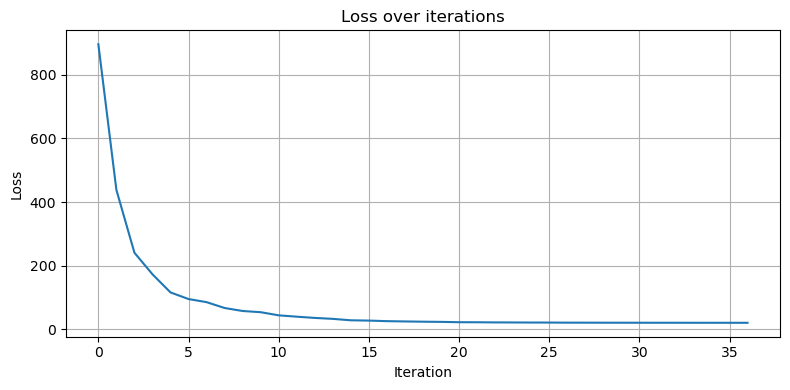

In [9]:
def armijo_step(y_u, y_l, W_lu, W_uu, grad, initial_step=1.0):
    current_loss = compute_loss(y_u, y_l, W_lu, W_uu)
    step = initial_step
    while True:
        y_u_new = y_u - step * grad
        new_loss = compute_loss(y_u_new, y_l, W_lu, W_uu)
        if new_loss <= current_loss - 0.1 * step * np.sum(grad**2):
            return step
        step *= 0.5

def gradient_descent_armijo(W_lu, W_uu, y_l, unlabeled_indices, max_iter=1000, tol=1e-2):
    y_u = np.zeros(len(unlabeled_indices), dtype=np.float64)
    hist = []
    prev_loss = np.inf
    
    for i in range(max_iter):
        grad = compute_grad(y_u, y_l, W_lu, W_uu)
        step_size = armijo_step(y_u, y_l, W_lu, W_uu, grad)
        y_u -= step_size * grad
        loss = compute_loss(y_u, y_l, W_lu, W_uu)
        grad_norm = np.linalg.norm(grad)
        hist.append({'iter': i, 'loss': loss, 'grad_norm': grad_norm, 'step_size': step_size})

        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss

    return y_u, pd.DataFrame(hist)

y_l = labels[labeled_indices].astype(np.float64)
y_u_armijo, hist_armijo = gradient_descent_armijo(W_lu, W_uu, y_l, unlabeled_indices)
plot_loss(hist_armijo)

In [10]:
hist_armijo

,iter,loss,grad_norm,step_size
0,0,895.711083,236.156487,0.062500
1,1,438.071494,306.022630,0.015625
2,2,240.840822,216.693795,0.007812
3,3,173.018592,75.219540,0.031250
4,4,116.068539,123.170032,0.007812
5,5,95.246984,49.346953,0.015625
6,6,85.512474,54.073259,0.015625
7,7,67.118785,71.461170,0.007812
8,8,57.717038,33.581395,0.015625
9,9,53.953426,38.932206,0.015625


# BCGD_GS

In [11]:
def BCGD_GS(y_u, y_l, W_lu, W_uu, max_iter=20000, tol=1e-6, patience=30, verbose=False):
    y_cur = y_u.copy()
    L = lipschitz_constant(W_lu, W_uu, np.arange(len(y_u)))
    eta = 1/L
    patience_count = 0
    loss_history = []
    best_loss = float('inf')

    for iter in range(max_iter):
        grad = compute_grad(y_cur, y_l, W_lu, W_uu)
        max_id = np.argmax(np.abs(grad))
        
        y_next = y_cur.copy()
        y_next[max_id] -= eta * grad[max_id]
        
        cur_loss = compute_loss(y_next, y_l, W_lu, W_uu)
        loss_history.append(cur_loss)

        if verbose and iter % 100 == 0:
            print(f"Iter {iter:05d} | Loss: {cur_loss:.6f} | Patience: {patience_count}/{patience}")

        if cur_loss < best_loss - tol:
            best_loss = cur_loss
            patience_count = 0
        else:
            patience_count += 1
        
        if patience_count >= patience:
            if verbose:
                print(f"Early stopping at iteration {iter} (no improvement for {patience} iterations)")
            break
        
        y_cur = y_next

    return y_cur, loss_history

In [12]:
y_l = labels[labeled_indices].astype(np.float64)
y_u_initial = np.zeros(len(unlabeled_indices))

y_u_optimized, loss_history = BCGD_GS(
    y_u_initial, 
    y_l, 
    W_lu, 
    W_uu, 
    max_iter=20000,
    verbose=True
)

Iter 00000 | Loss: 2289.780036 | Patience: 0/30
Iter 00100 | Loss: 2173.897607 | Patience: 0/30
Iter 00200 | Loss: 2047.670088 | Patience: 0/30
Iter 00300 | Loss: 1935.223671 | Patience: 0/30
Iter 00400 | Loss: 1846.033150 | Patience: 0/30
Iter 00500 | Loss: 1765.151319 | Patience: 0/30
Iter 00600 | Loss: 1687.337338 | Patience: 0/30
Iter 00700 | Loss: 1616.023183 | Patience: 0/30
Iter 00800 | Loss: 1551.824609 | Patience: 0/30
Iter 00900 | Loss: 1488.365901 | Patience: 0/30
Iter 01000 | Loss: 1427.284540 | Patience: 0/30
Iter 01100 | Loss: 1372.001945 | Patience: 0/30
Iter 01200 | Loss: 1320.427420 | Patience: 0/30
Iter 01300 | Loss: 1269.849665 | Patience: 0/30
Iter 01400 | Loss: 1221.238038 | Patience: 0/30
Iter 01500 | Loss: 1175.577474 | Patience: 0/30
Iter 01600 | Loss: 1134.381045 | Patience: 0/30
Iter 01700 | Loss: 1092.178630 | Patience: 0/30
Iter 01800 | Loss: 1053.774571 | Patience: 0/30
Iter 01900 | Loss: 1012.930827 | Patience: 0/30
Iter 02000 | Loss: 980.525302 | Patience

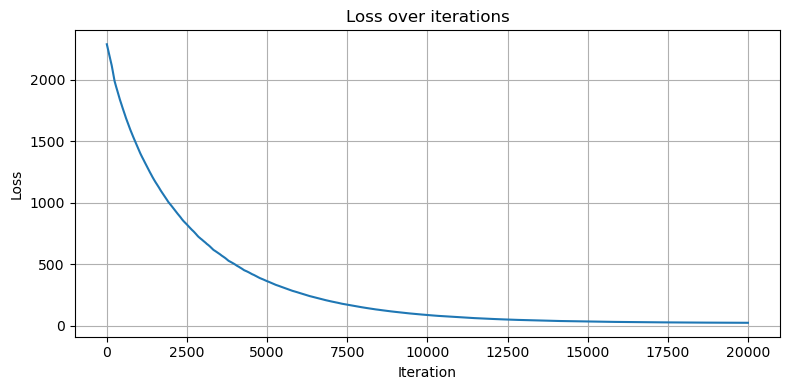

In [13]:
plot_loss(pd.DataFrame({'iter': range(len(loss_history)), 'loss': loss_history}))

# Coordinate Minimization

In [14]:
def coordinate_minimization(y_u, y_l, W_lu, W_uu, max_iter=5000, tol=1e-2, verbose=False):
    y_opt = y_u.copy()
    loss_history = []
    n = len(y_opt)
    
    for k in range(max_iter):
        y_prev = y_opt.copy()
        
        for i in range(n):
            numerator = np.sum(W_lu[:,i]*y_l) + np.sum(W_uu[i,:]*y_opt)
            denominator = np.sum(W_lu[:,i]) + np.sum(W_uu[i,:])
            y_opt[i] = numerator / denominator
        
        current_loss = compute_loss(y_opt, y_l, W_lu, W_uu)
        loss_history.append(current_loss)
        
        if k > 0 and abs(loss_history[-2] - current_loss) < tol:
            break
            
    return y_opt, loss_history

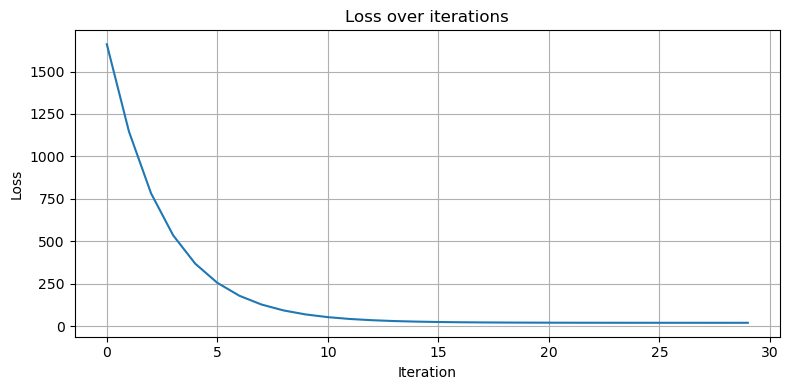

In [13]:
y_opt, losses = coordinate_minimization(
    np.zeros(len(unlabeled_indices)),
    labels[labeled_indices].astype(np.float64),
    W_lu,
    W_uu
)
plot_loss(pd.DataFrame({'iter': range(len(losses)), 'loss': losses}))

# Real Dataset

## Dataset Specification

**Source**: Modified subset of UCI Covertype Dataset  
**Original Task**: Forest cover type prediction  
**Our Subset**: Binary classification of two conifer species  

### Classes
| Binary Label | Original Class | Tree Species          | Samples (Total=1,000) |
|--------------|-----------------|-----------------------|-----------------------|
| +1           | '2'             | Lodgepole Pine        | 468                   |
| -1           | '3'             | Ponderosa Pine        | 532                   |

### Features (All standardized)
1. **Elevation**: Meters above sea level  
2. **Aspect**: Compass direction of slope (0-360°)  
3. **Slope**: Angle of incline (degrees)  

In [15]:
# Data loading
data = fetch_openml('covertype', version=3)
subset_mask = data.target.isin(['2', '3'])
X = data.data[subset_mask][['Elevation', 'Aspect', 'Slope']].values
y = (data.target[subset_mask] == '2').astype(int)*2-1
X = StandardScaler().fit_transform(X[:1000])
y = y[:1000].values

X_labeled, _, y_labeled, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)
labeled_indices = np.where(np.isin(X, X_labeled).all(axis=1))[0]
unlabeled_indices = np.array([i for i in range(len(y)) if i not in labeled_indices])
y_l = y[labeled_indices]
y_true = y[unlabeled_indices]

W_lu = similarity_matrix(X[labeled_indices], X[unlabeled_indices])
W_uu = similarity_matrix(X[unlabeled_indices], X[unlabeled_indices])
W_uu[W_uu < 0.7] = 0
np.fill_diagonal(W_uu, 0)
 

# Accuracy vs Runtime

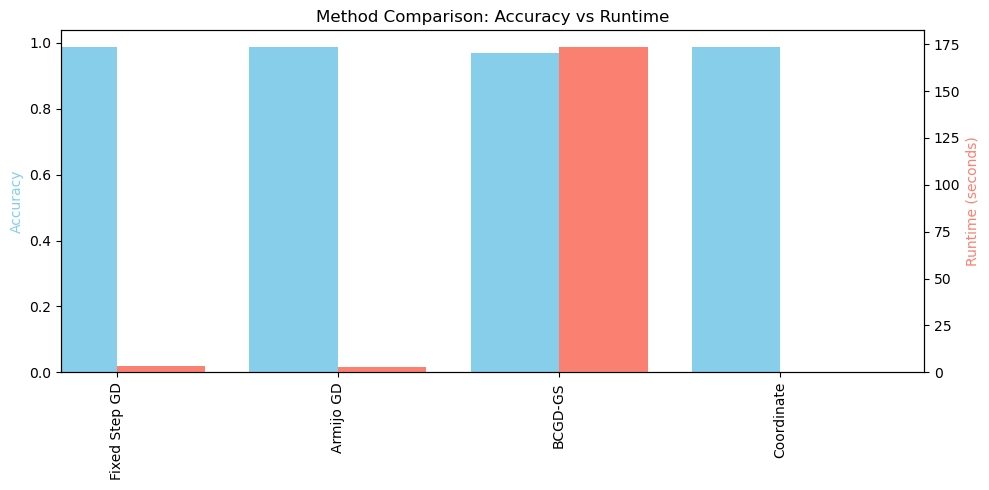

In [17]:
methods = {
    'Fixed Step GD': gradient_descent_fixed_step,
    'Armijo GD': gradient_descent_armijo,
    'BCGD-GS': BCGD_GS,
    'Coordinate': coordinate_minimization
}

results = {}
y_u_init = np.zeros(len(unlabeled_indices), dtype=np.float64)

for name, method in methods.items():
    start = time.time()
    if name in ['BCGD-GS', 'Coordinate']:
        y_pred, _ = method(y_u_init.copy(), y_l, W_lu, W_uu)
    else:
        y_pred, _ = method(W_lu, W_uu, y_l, unlabeled_indices)
    runtime = time.time() - start
    accuracy = accuracy_score(y_true, np.sign(y_pred))
    results[name] = {'Accuracy': accuracy, 'Runtime': runtime}

metrics = pd.DataFrame(results).T

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

metrics['Accuracy'].plot(kind='bar', color='skyblue', ax=ax1, width=0.4, position=1)
metrics['Runtime'].plot(kind='bar', color='salmon', ax=ax2, width=0.4, position=0)

ax1.set_ylabel('Accuracy', color='skyblue')
ax2.set_ylabel('Runtime (seconds)', color='salmon')
ax1.set_title('Method Comparison: Accuracy vs Runtime')

plt.tight_layout()
plt.show()

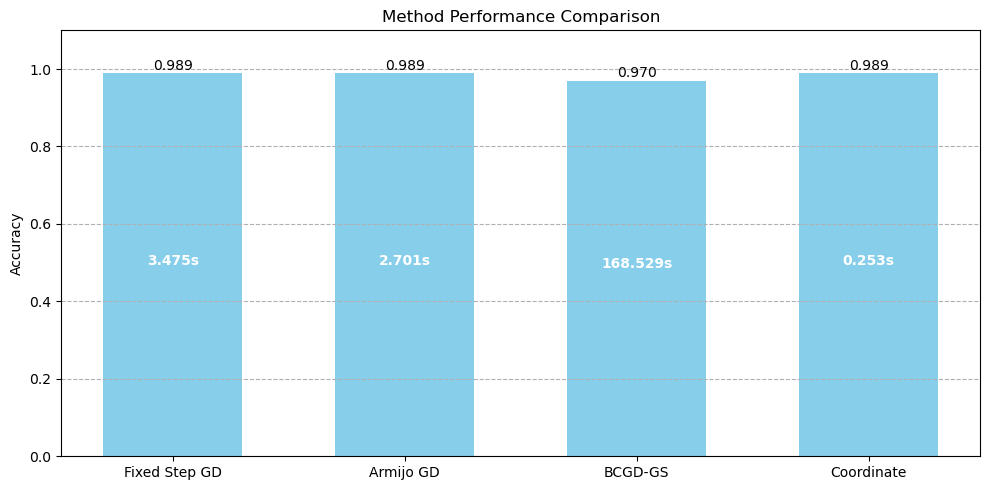

In [24]:
methods = {
    'Fixed Step GD': gradient_descent_fixed_step,
    'Armijo GD': gradient_descent_armijo,
    'BCGD-GS': BCGD_GS,
    'Coordinate': coordinate_minimization
}

results = {}
y_u_init = np.zeros(len(unlabeled_indices), dtype=np.float64)

for name, method in methods.items():
    start = time.time()
    if name in ['BCGD-GS', 'Coordinate']:
        y_pred, _ = method(y_u_init.copy(), y_l, W_lu, W_uu)
    else:
        y_pred, _ = method(W_lu, W_uu, y_l, unlabeled_indices)
    runtime = time.time() - start
    accuracy = accuracy_score(y_true, np.sign(y_pred))
    results[name] = {'Accuracy': accuracy, 'Runtime': runtime}

metrics = pd.DataFrame(results).T

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(metrics.index, metrics['Accuracy'], color='skyblue', width=0.6)

for i, (name, row) in enumerate(metrics.iterrows()):
    ax.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.3f}", ha='center')
    ax.text(i, row['Accuracy']/2, f"{row['Runtime']:.3f}s", ha='center', color='white', weight='bold')

ax.set_ylim(0, 1.1)
ax.set_ylabel('Accuracy')
ax.set_title('Method Performance Comparison')
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Re-evaluating BCGD-GS Performance|

Since BCGD-GS showed significantly longer runtime while achieving high accuracy in our initial tests, we'll run another detailed evaluation to:

1. Verify if the performance gap persists across multiple runs
2. Analyze where the computational time is being spent
3. Determine if the accuracy improvement justifies the additional computation time

We'll execute the same BCGD-GS implementation on our Covertype dataset subset, tracking:
- Iteration-by-iteration convergence 
- Final classification metrics
 

Iter 00000 | Loss: 16118.694945 | Patience: 0/30
Iter 00100 | Loss: 14517.168763 | Patience: 0/30
Iter 00200 | Loss: 12912.928585 | Patience: 0/30
Iter 00300 | Loss: 11577.163583 | Patience: 0/30
Iter 00400 | Loss: 10714.679871 | Patience: 0/30
Iter 00500 | Loss: 9974.263482 | Patience: 0/30
Iter 00600 | Loss: 9229.703478 | Patience: 0/30
Iter 00700 | Loss: 8529.418811 | Patience: 0/30
Iter 00800 | Loss: 7890.889576 | Patience: 0/30
Iter 00900 | Loss: 7434.711703 | Patience: 0/30
Iter 01000 | Loss: 7090.893958 | Patience: 0/30
Iter 01100 | Loss: 6729.687111 | Patience: 0/30
Iter 01200 | Loss: 6331.692367 | Patience: 0/30
Iter 01300 | Loss: 5928.414045 | Patience: 0/30
Iter 01400 | Loss: 5563.450592 | Patience: 0/30
Iter 01500 | Loss: 5259.990079 | Patience: 0/30
Iter 01600 | Loss: 5009.197693 | Patience: 0/30
Iter 01700 | Loss: 4822.621318 | Patience: 0/30
Iter 01800 | Loss: 4624.877773 | Patience: 0/30
Iter 01900 | Loss: 4432.256157 | Patience: 0/30
Iter 02000 | Loss: 4216.239144 | Pa

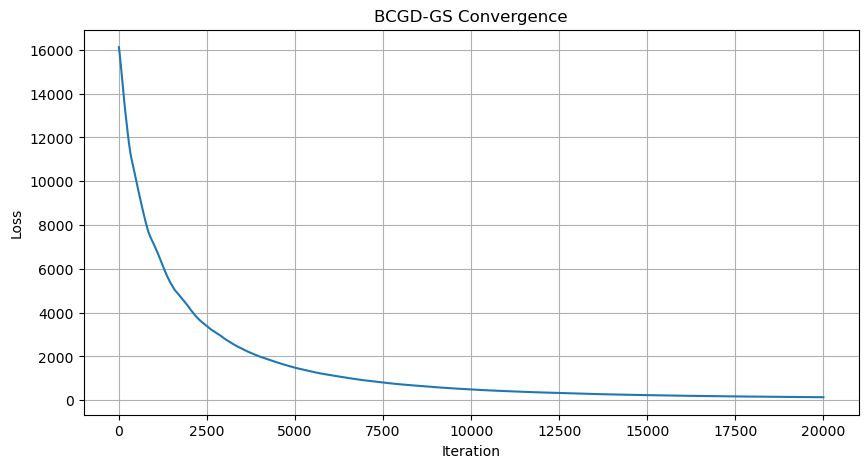

In [29]:
# Initialize and run BCGD_GS
y_u_initial = np.zeros(len(unlabeled_indices))
y_l = y[labeled_indices].astype(np.float64)

y_u_optimized, loss_history = BCGD_GS(
    y_u_initial, 
    y_l, 
    W_lu, 
    W_uu, 
    max_iter=20000,
    verbose=True
)

accuracy = accuracy_score(y_true, np.sign(y_u_optimized))
print(f"\nFinal Accuracy: {accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('BCGD-GS Convergence')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Another Dataset

In [16]:
from sklearn.datasets import fetch_openml
banknotes = fetch_openml('banknote-authentication', version=1)
X = StandardScaler().fit_transform(banknotes.data)
y = (banknotes.target.astype(int)*2-1).values


X_labeled, _, y_labeled, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)
labeled_indices = np.where(np.isin(X, X_labeled).all(axis=1))[0]
unlabeled_indices = np.array([i for i in range(len(y)) if i not in labeled_indices])
y_l = y[labeled_indices]
y_true = y[unlabeled_indices]

W_lu = similarity_matrix(X[labeled_indices], X[unlabeled_indices])
W_uu = similarity_matrix(X[unlabeled_indices], X[unlabeled_indices])
W_uu[W_uu < 0.7] = 0
np.fill_diagonal(W_uu, 0)

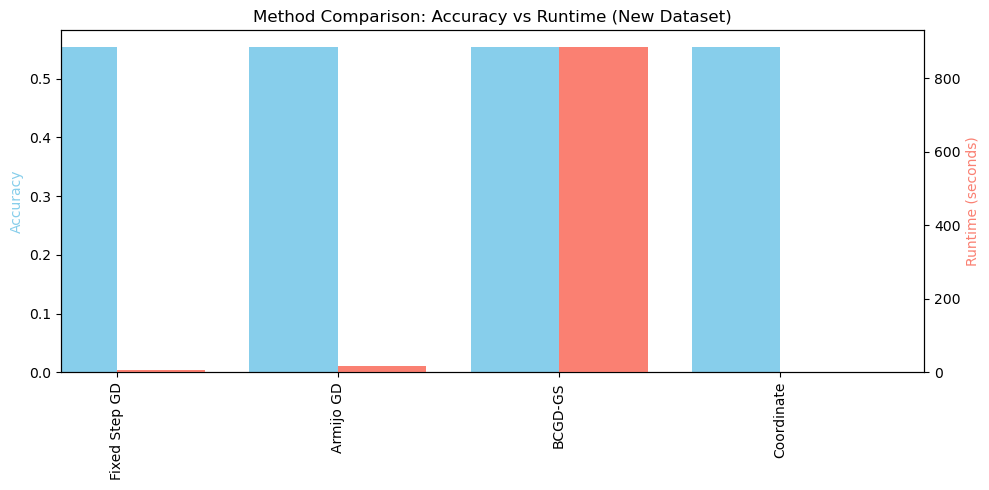

Iter 00000 | Loss: 63468.689054 | Patience: 0/30
Iter 00100 | Loss: 57669.131400 | Patience: 0/30
Iter 00200 | Loss: 53183.638999 | Patience: 0/30
Iter 00300 | Loss: 50062.713676 | Patience: 0/30
Iter 00400 | Loss: 47415.054613 | Patience: 0/30
Iter 00500 | Loss: 45067.835271 | Patience: 0/30
Iter 00600 | Loss: 43033.564876 | Patience: 0/30
Iter 00700 | Loss: 41355.642849 | Patience: 0/30
Iter 00800 | Loss: 39845.716777 | Patience: 0/30
Iter 00900 | Loss: 38280.412995 | Patience: 0/30
Iter 01000 | Loss: 36809.746502 | Patience: 0/30
Iter 01100 | Loss: 35489.955892 | Patience: 0/30
Iter 01200 | Loss: 34211.186306 | Patience: 0/30
Iter 01300 | Loss: 33012.126515 | Patience: 0/30
Iter 01400 | Loss: 31951.393905 | Patience: 0/30
Iter 01500 | Loss: 30973.861656 | Patience: 0/30
Iter 01600 | Loss: 30113.291240 | Patience: 0/30
Iter 01700 | Loss: 29217.141831 | Patience: 0/30
Iter 01800 | Loss: 28408.124708 | Patience: 0/30
Iter 01900 | Loss: 27641.807412 | Patience: 0/30
Iter 02000 | Loss: 2

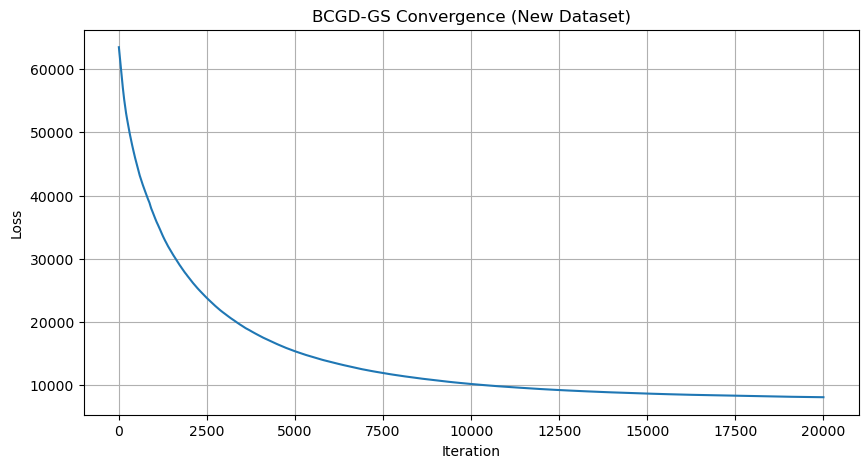

In [17]:
# Run all methods on the new dataset
methods = {
    'Fixed Step GD': gradient_descent_fixed_step,
    'Armijo GD': gradient_descent_armijo,
    'BCGD-GS': BCGD_GS,
    'Coordinate': coordinate_minimization
}

results = {}
y_u_init = np.zeros(len(unlabeled_indices), dtype=np.float64)

for name, method in methods.items():
    start = time.time()
    if name in ['BCGD-GS', 'Coordinate']:
        y_pred, _ = method(y_u_init.copy(), y_l, W_lu, W_uu)
    else:
        y_pred, _ = method(W_lu, W_uu, y_l, unlabeled_indices)
    runtime = time.time() - start
    accuracy = accuracy_score(y_true, np.sign(y_pred))
    results[name] = {'Accuracy': accuracy, 'Runtime': runtime}

# Create a DataFrame for results
metrics = pd.DataFrame(results).T

# Plot Accuracy vs Runtime
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

metrics['Accuracy'].plot(kind='bar', color='skyblue', ax=ax1, width=0.4, position=1)
metrics['Runtime'].plot(kind='bar', color='salmon', ax=ax2, width=0.4, position=0)

ax1.set_ylabel('Accuracy', color='skyblue')
ax2.set_ylabel('Runtime (seconds)', color='salmon')
ax1.set_title('Method Comparison: Accuracy vs Runtime (New Dataset)')

plt.tight_layout()
plt.show()

# Detailed visualization for BCGD-GS
y_u_optimized, loss_history = BCGD_GS(
    y_u_init.copy(),
    y_l,
    W_lu,
    W_uu,
    max_iter=20000,
    verbose=True
)

accuracy = accuracy_score(y_true, np.sign(y_u_optimized))
print(f"\nFinal Accuracy (BCGD-GS): {accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('BCGD-GS Convergence (New Dataset)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()